In [1]:
using Images
using ImageView
using FileIO
using Colors
using StatsBase
using CoordinateTransformations

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/felix/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/felix/snap/code/common/.cache/gio-modules/libgiolibproxy.so


In [2]:
function GetImageGrid(ImagingParams,fnamefunc=fnameFocused)
    #=
    Here we jsut make an array of the image names to be loaded
    =#
    x, y = GetIdentifiers(ImagingParams)
    x = reverse(x)
    y = reverse(y)
    img_name_grid = Array{String}(undef,length(y), length(x))
    img_pos_grid = Array{Float64}(undef,length(y), length(x), 2)
    for i in eachindex(x)
        for j in eachindex(y)
            img_name_grid[j,i]  = fnamefunc(x[i],y[j],ImagingParams.exposure)
            img_pos_grid[j,i,:] = GeneratePxCoordinates([x[i],y[j]], ImagingParams)
        end
    end
    return img_name_grid[end:-1:1,end:-1:1], img_pos_grid[end:-1:1,end:-1:1,:]
end
function fnameFocused(x,y,e)
return "Focused_y=$(x)_z=$(y)_e=$(e).png"
end
function GetIdentifiers(ImagingParams)
    files = readdir(ImagingParams.path)
    f_y_z_exp = [split(i, "_") for i in files]
    f_y_z = [ endswith(i[end], ".png") ? [i[1],parse(Int, String(split(i[2],"=")[2])), parse(Int, String(split(i[3], "=")[2]))] : ["F", -1, -1] for i in f_y_z_exp]
    y = unique([i[2] for i in f_y_z])
    z = unique([i[3] for i in f_y_z])
    y = sort(y)
    if -1 in y
        deleteat!(y, findall(x->x==-1, y))
    end
    z = sort(z)
    if -1 in z
        deleteat!(z, findall(x->x==-1, z))
    end
    return y, z
end
function GeneratePxCoordinates(pos, ImagingParams)
    #Function to determine the expected position of images
    return pos .* ImagingParams.steps_per_mm ./ (ImagingParams.px_size/ImagingParams.magnification)
end
struct ImagingParameters
    exposure::String
    magnification::Float64
    px_size::Float64
    steps_per_mm::Float64
    overlap::Float64
    path::String
    save_path::String
    bps::Int64
    im_width::Int64
    im_height::Int64
end

In [3]:
function image_rotate(img,angle)
    ref = similar(img)
    ref .= 1
    ref = imrotate(ref,angle)
    res = imrotate(img,angle)
    ref[res .!= 0] .= 1
    return ref, res
end

image_rotate (generic function with 1 method)

In [4]:
### Minimizing image difference between images through rotation and shifts
IP =ImagingParameters("NoIR", 2, 1.55*10^-3, 0.00012397, 0.5, "/home/felix/rapid_storage_2/Leaf/", "/home/felix/rapid_storage_2/Leaf/combined/", 16, 4056, 3040)
img_name_grid, img_pos_grid = GetImageGrid(IP)
pre_offset = [230,90]

2-element Vector{Int64}:
 230
  90

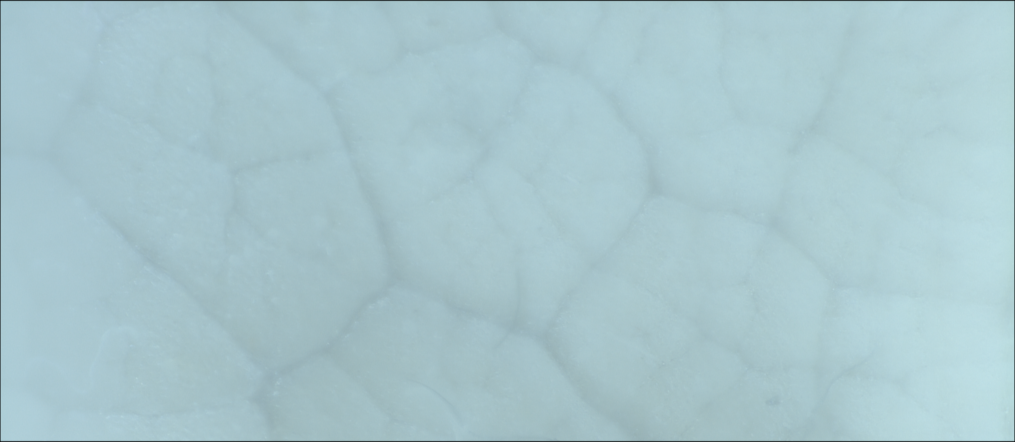

In [5]:
img1 = load("$(IP.path)$(img_name_grid[4,5])")
coord1 = img_pos_grid[4,5,:]
img2 = load("$(IP.path)$(img_name_grid[4,6])")
coord2 = img_pos_grid[4,6,:]
# Normalize to selection
coord2 .-= coord1
coord1 .-= coord1
coord2 = trunc.(Int, coord2)
coord1 = trunc.(Int, coord1)
extend = 10
rotExtend = 5

# Grab relevant portion of image
img2 = img2[coord2[1]-pre_offset[1]-extend:end, 1:end]
img1 = img1[1:(end-coord2[1]+1+pre_offset[1]+extend), 1:end]

In [10]:
# Iterate possible shift space
shifts = [i for i = -extend:extend] .+ pre_offset[1]
rotations = [i for i = -rotExtend:0.5:rotExtend] ./ 180 .* pi
res = zeros(length(shifts),length(rotations), 3)
for i in eachindex(shifts)
    for j in eachindex(rotations)
        # Shift then rotaate
        img1_rot = imrotate(img1[1:end-shifts[i]+1, 1:end], rotations[j])
        # Now we fix its dimensions so its central and same size as img2
        off = trunc.(Int, (size(img1_rot) .- size(img2[shifts[i]:end, 1:end])) ./4)
        if off[1] == 0 
            img1_rot = img1_rot[1:end-off[1],:]
        else
            img1_rot = img1_rot[off[1]:end-off[1], :]
        end
        if off[2] == 0
            img1_rot = img1_rot[:, 1:end-off[2]]
        else
            img1_rot = img1_rot[:, off[2]:end-off[2]]
        end

        # Staying with this dtype we need to do both ways around and merge
        extra = (size(img1_rot) .- size(img2[shifts[i]+1:end, 1:end]))
        residue = img2[shifts[i]+1:end, 1:end] .- img1_rot[1:end-extra[1], 1:end-extra[2]]
        resOppo = img1_rot[1:end-extra[1], 1:end-extra[2]] .- img2[shifts[i]+1:end, 1:end]
        residue[residue .== RGB{N0f8}(0,0,0)] .= resOppo[residue .== RGB{N0f8}(0,0,0)]
        # Zero and rescale so that color view is accepted
        residue = float(channelview(residue))
        res[i,j,1] = abs(mean(residue))
        res[i,j,2] = abs(1-sum(residue.!=0)/length(residue))
        res[i,j,3] = std(residue)
    end
end

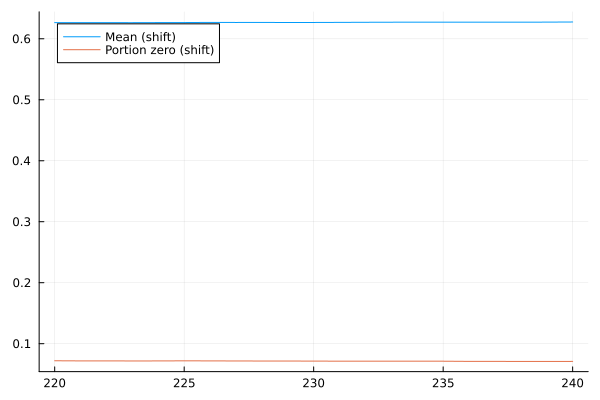

In [11]:
using Plots
plot(shifts, res[:,11,1], label="Mean (shift)")
plot!(shifts, res[:,11,2], label="Portion zero (shift)")
#yerror!(shifts, res[:,1], yerror=res[:,2])

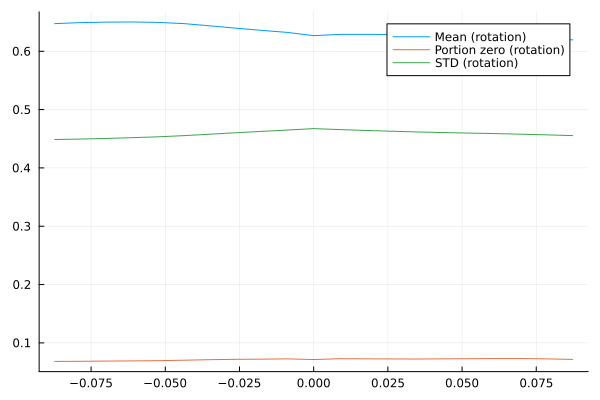

In [12]:
plot(rotations, res[extend+1,:,1], label="Mean (rotation)")
plot!(rotations, res[extend+1,:,2], label="Portion zero (rotation)")
plot!(rotations, res[extend+1,:,3], label="STD (rotation)")

(1, 21)

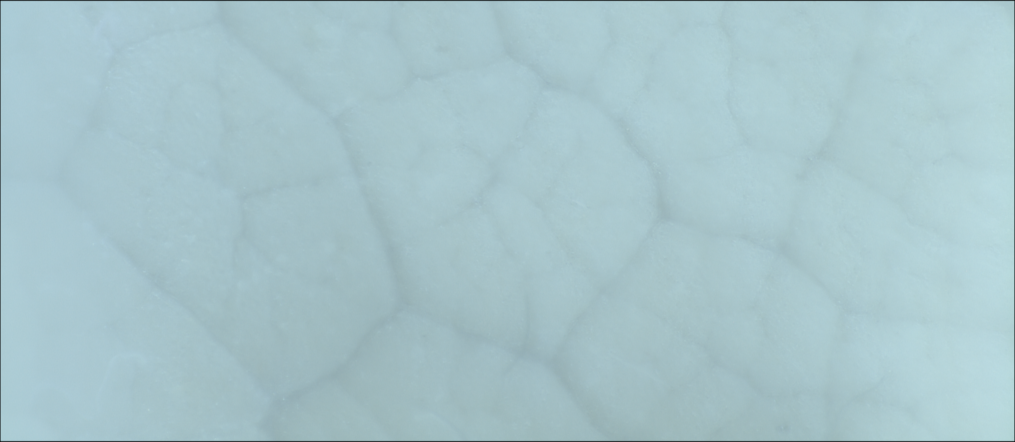

In [16]:
img2

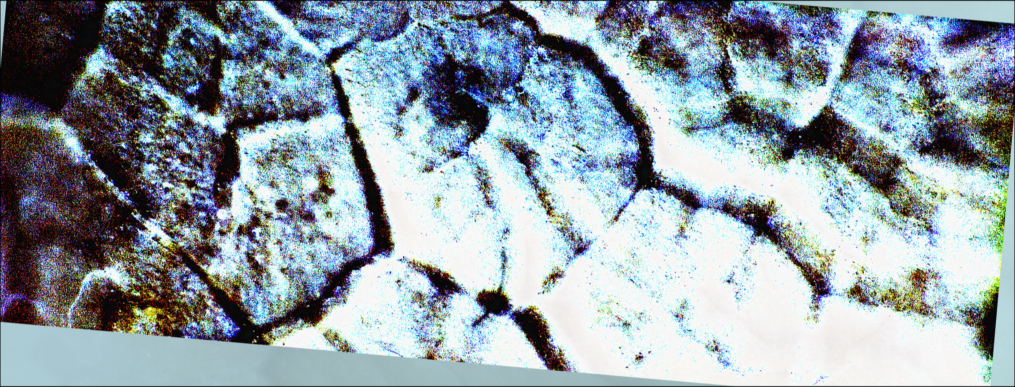

In [15]:
i,j = findmin(res[:,:,1])[2][1],findmin(res[:,:,1])[2][2]
img1_rot = imrotate(img1[1:end-shifts[i]+1, 1:end], rotations[j])
# Now we fix its dimensions so its central and same size as img2
off = trunc.(Int, (size(img1_rot) .- size(img2[shifts[i]:end, 1:end])) ./4)
if off[1] == 0 
    img1_rot = img1_rot[1:end-off[1],:]
else
    img1_rot = img1_rot[off[1]:end-off[1], :]
end
if off[2] == 0
    img1_rot = img1_rot[:, 1:end-off[2]]
else
    img1_rot = img1_rot[:, off[2]:end-off[2]]
end

# Staying with this dtype we need to do both ways around and merge
extra = (size(img1_rot) .- size(img2[shifts[i]+1:end, 1:end]))
residue = img2[shifts[i]+1:end, 1:end] .- img1_rot[1:end-extra[1], 1:end-extra[2]]

In [3]:
using JLD2 
save_path = "/home/felix/rapid_storage_1/Wasp/Stitched/"
conf = load_object("$(save_path)stitch.jld2")
size(conf["I"])

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 ~/.julia/packages/JLD2/cHcDY/src/JLD2.jl:287


LoadError: SystemError: opening file "/home/felix/rapid_storage_1/Wasp/Stitched/stitch.jld2": No such file or directory

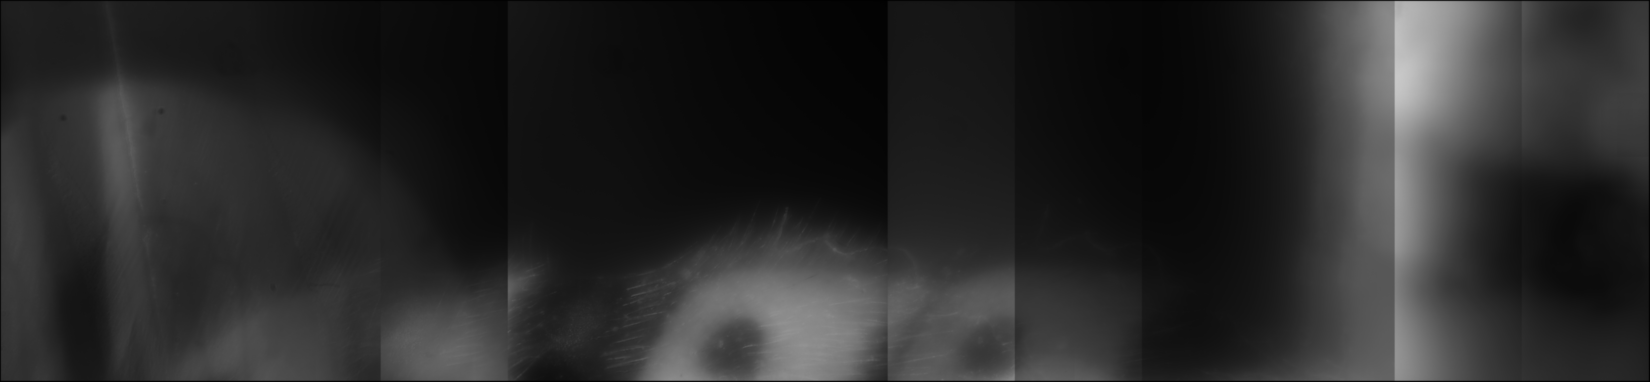

In [40]:
Gray.(reinterpret(N0f8, conf["I"]).^2)